# (2): Azimuthally-Averaged Radial Profiles

The two key assumptions in the modeling for this project are that the continuum emission is geometrically "flat" (i.e., it has no vertical extent out of the midplane) and axisymmetric (i.e., there is no variation in the emission as a function of azimuth angle, $\theta$).  Therefore, we're assuming the emission can be described entirely as a 1-D function of radius ($r$, distance from the host star at the center).  This is actually a pretty good zeroth order assumption from a physical standpoint, although at these very high resolutions we will see some deviations of that behavior (certainly from axisymmetry, but perhaps also from the vertically flat approximation).  We'll cross that bridge when/if we get to it.

Now, the observed emission does not look like symmetric, like circles, because it is projected onto the sky at some inclination angle ($i$) and orientation (commonly taken to be the PA of the projected major axis).  The next step toward developing some intuition and guidance toward modeling the emission requires us to make these assumptions and examine the data in a condensed format: a 1-D azimuthally-averaged radial profile.  This notebook will explain how to deproject that sky view and the azimuthal averaging, to help set you up to experiment with some 1st-pass modeling.    

**Set up:**

First, we'll repeat some steps from the previous notebook to load in and parse the image data (adding in a few more useful packages).

In [1]:
import os, sys, time           # I basically always load these in every code I write.
import numpy as np             # Numpy is the basic numerics package in Python.
from astropy.io import fits    # .FITS file manipulation package  
import urllib.request          # package for fetching files off the internet
import matplotlib.pyplot as plt    # plotting package
from scipy.interpolate import interp1d    # 1-dimensional interpolation package   
from matplotlib.patches import Ellipse    # simple ellipse plotting utility
import cmasher as cmr          # color maps
from astropy.visualization import (AsinhStretch, LogStretch, ImageNormalize)    # image visualization packages
from skimage import transform, measure    # some tools to rotation and stretch images
from scipy.ndimage.interpolation import shift    # tool for image interpolation
%matplotlib inline                

# disk target name
disk_name = 'SR4'

# load the .FITS file into a 2-D array (image) and header dictionary (header)
data = fits.open(disk_name+'_continuum.fits')    # this presumes you've done the 1st notebook and have the datafile
image = np.squeeze(data[0].data)
header = data[0].header

# number of pixels in RA, DEC dimensions
nx, ny = header['NAXIS1'], header['NAXIS2']

# coordinate frames can be reconstructed from a mapping to pixels with header variables
offRA, offDEC = -0.060, -0.509    
RAo = 3600 * header['CDELT1'] * (np.arange(nx) - (header['CRPIX1'] - 1)) - offRA
DECo = 3600 * header['CDELT2'] * (np.arange(ny) - (header['CRPIX2'] - 1)) - offDEC

# now convert these to two-dimensional arrays of RA and DEC offsets from the disk center for each pixel
dRA, dDEC = np.meshgrid(RAo, DECo)

# get the beam parameters (in **arcseconds** for the FWHM, and **degrees** for the position angle)
beam_maj, beam_min, beam_PA = 3600 * header['BMAJ'], 3600 * header['BMIN'], header['BPA']

# compute the beam area (in **steradians**)
# trust me...this is tricky, but the first part is the integral of the 2-D gaussian PSF
beam_area = (np.pi * beam_maj * beam_min / (4 * np.log(2))) / (3600 * 180 / np.pi)**2

**(A) Coordinate Transformation:**

The key step here is to transform from the sky-plane coordinate frame (the data) to the disk-plane coordinate frame.  This involves a rotation (to account for the observed PA), a deprojection (to account for the observed inclination), and a transformation from Cartesian (RA, DEC offsets) to cylindrical polar (radius, azimuth, or {$r$, $\theta$}) coordinate systems (code-wise, these happen roughly simultaneously).  

In [2]:
# set the inclination and PA of the disk onto the sky-frame
incl, PA = 22., 26.   # these were measured by the DSHARP consortium (Huang et al. 2018, ApJL, 869, L42 - Table 2)

# convert these to radius
inclr, PAr = np.radians(incl), np.radians(PA)

# deproject and rotate to new coordinate frame
xp = (dRA * np.cos(PAr) - dDEC * np.sin(PAr)) / np.cos(inclr)
yp = (dRA * np.sin(PAr) + dDEC * np.cos(PAr))

# now convert to polar coordinates (r in arcseconds, theta in degrees)
# note that theta starts along the minor axis (theta = 0), and rotates clockwise in the sky plane)
r = np.sqrt(xp**2 + yp**2)
theta = np.degrees(np.arctan2(yp, xp))

**(B) "Unwrap" the Image into Polar Coordinates, Average into Radial Profile:**

The next part is to transform the image into the ($r$, $\theta$)-plane.  If our assumptions (see above) are correct, and the adopted offsets, $i$, and PA are appropriate, this should look like straight lines at fixed $r$ (i.e., "stripes").  We will average the image onto a fixed grid in this polar-plane.

In [4]:
# radius and azimuth bin centers (and their widths)
rbins = np.linspace(0.005, 1.5, 300)    # in arcseconds
tbins = np.linspace(-180, 180, 181)     # in degrees
dr = np.abs(rbins[1] - rbins[0])
dt = np.abs(tbins[1] - tbins[0])

# initialize the (r, az)-map and radial profile
rtmap = np.empty((len(tbins), len(rbins)))
SBr, err_SBr = np.empty(len(rbins)), np.empty(len(rbins))

# loop through the bins to populate the (r, az)-map and radial profile
for i in range(len(rbins)):
    # identify pixels that correspond to the radial bin (i.e., in this annulus)
    in_annulus = ((r >= (rbins[i] - 0.5 * dr)) & (r < (rbins[i] + 0.5 * dr)))
    
    # accumulate the azimuth values and surface brightness values in this annulus
    az_annulus = theta[in_annulus]
    SB_annulus = image[in_annulus]
    
    # average the intensities (and their scatter) in the annulus
    SBr[i], err_SBr[i] = np.average(SB_annulus), np.std(SB_annulus)
    
    # populate the azimuthal bins for the (r, az)-map at this radius
    for j in range(len(tbins)):
        # identify pixels that correspond to the azimuthal bin
        in_wedge = ((az_annulus >= (tbins[j] - 0.5 * dt)) & (az_annulus < (tbins[j] + 0.5 * dt)))
        
        # if there are pixels in that bin, average the corresponding intensities
        if (len(SB_annulus[in_wedge]) > 0):
            rtmap[j,i] = np.average(SB_annulus[in_wedge])
        else:
            rtmap[j,i] = -1e10    # this is a temporary placeholder; it will be fixed in next piece of code
            
# now "fix" the (r, az)-map where there are too few pixels in certain az bins (inner disk)
# its ok if this part is a "black box": it is not important / relevant
for i in range(len(rbins)):
    # extract an azimuthal slice of the (r, az)-map
    az_slice = rtmap[:,i]
    
    # identify if there's missing information in an az bin along that slice:
    # if so, fill it in with linear interpolation along the slice
    if np.any(az_slice < -1e5):
        # extract non-problematic bins in the slice
        x_slice, y_slice = tbins[az_slice >= -1e5], az_slice[az_slice >= -1e5]
        
        # pad the arrays to make sure they span a full circle in azimuth
        x_slice_ext = np.pad(x_slice, 1, mode='wrap')
        x_slice_ext[0] -= 360.
        x_slice_ext[-1] += 360.
        y_slice_ext = np.pad(y_slice, 1, mode='wrap')
        
        # define the interpolation function
        raz_func = interp1d(x_slice_ext, y_slice_ext, bounds_error=True)
        
        # interpolate and replace those bins in the (r, az)-map
        fixed_slice = raz_func(tbins)
        rtmap[:,i] = fixed_slice

Now we can plot the image in polar coordinates:

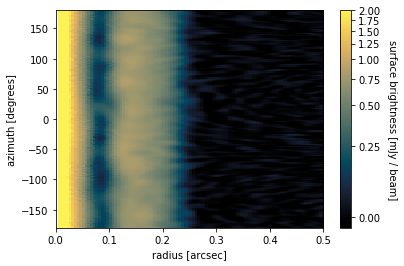

In [5]:
# define the full (r, az)-map boundaries with a list of the min/max (r, az) bins
rtmap_bounds = (rbins.min(), rbins.max(), tbins.min(), tbins.max())

# set the radius and azimuth ranges you want to show
t_lims = [-180, 180]      
r_lims = [0, 0.5]

# now define the color-map, intensity limits, and stretch
cmap = cmr.eclipse
vmin, vmax = -0.03, 2    # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

# set up and plot the image on the specified scale
fig, ax = plt.subplots()
im = ax.imshow(1e3*rtmap, origin='lower', cmap=cmap, extent=rtmap_bounds, norm=norm, aspect='auto')
ax.set_xlim(r_lims)
ax.set_ylim(t_lims)
ax.set_ylabel('azimuth [degrees]')
ax.set_xlabel('radius [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=17)

**(C) Plot the 1-D radial profile**

The polar coordinate plot above is basically a 2-D expansion of the 1-D radial profile.  You would get the latter by averaging the former along the azimuth axis.  We calculated this azimuthally-averaged profile while populating the polar map, and here we can plot it in both linear and logarithmic scalings.  When moving to a 1-D description, the Jy/beam units are no longer useful (or, meaningful).  Instead, we will swap to Jy / arcsec$^2$.

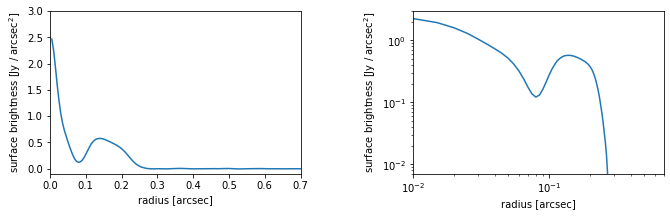

In [6]:
# convert from Jy / beam --> Jy / arcsec**2
SBr_0 = SBr / (beam_area * (3600 * 180 / np.pi)**2)
err_SBr_0 = err_SBr / (beam_area * (3600 * 180 / np.pi)**2)

# let's save this profile into a text (ASCII) file for later use
prof = list(zip(rbins, SBr_0, err_SBr_0))
np.savetxt(disk_name+'_cleanSBr.txt', prof, fmt='%.6e', header='rarcsec, SBr, err_SBr')

# set up the plots
fig, axs = plt.subplots(ncols=2, figsize=(11,3))

# the profile on a linear scaling
ax = axs[0]
ax.plot(rbins, SBr_0)
ax.set_xlim([0, 0.7])
ax.set_ylim([-0.1, 3])
ax.set_xlabel('radius [arcsec]')
ax.set_ylabel('surface brightness [Jy / arcsec$^2$]')

# the profile on a logarithmic scaling
ax = axs[1]
ax.plot(rbins, SBr_0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.01, 0.7])
ax.set_ylim([0.007, 3])
ax.set_xlabel('radius [arcsec]')
ax.set_ylabel('surface brightness [Jy / arcsec$^2$]')

# helps separate the plots
fig.subplots_adjust(wspace=0.45)

**Activities:**

So, once you have experimented with the code above, there are some useful things to try on your own.  

- Write a python function that takes in the name of a FITS file as its parameter, keywords including (RA, DEC) offsets, inclination angle, and PA (and perhaps more as needed), and returns an 'object' with the attributes {azimuthally deprojected polar image, and a tuple for the radial profile (radius, intensity)}.  Think about additional keywords you might want to make this more handy.  BONUS: Consider returning "figure" objects if requested, so plots can be readily made.

- Convert polar plots and surface brightness profiles into brightness temperature units. 

- Compare the radial profiles derived from a variety of polar angles with each other and with the azimuthal average profile (use the rtmap for the specific angles).  Is there any sign of azimuthal variation?

- Try to create a "simple" model for the brightness profile of the SR 4 disk.  You might try a central Gaussian "core" with another Gaussian "ring".  Tune the parameters to get a feel for the model.  Think about and experiment with how you might account for the "extra" emission in the ring (perhaps another Gaussian?).  This is just an experiment to develop some intuition: you do not have to get a good fit: we'll use some other machinery for that.  

In [ ]:
# your code here